In [1]:
#Katherine Van Kirk
#kvankirk@g.harvard.edu

import numpy as np
import matplotlib.pyplot as plt
import copy
import math
from math import e
import random 
import ast
import time
import jax
from neural_tangents import stax
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import copy

# Kernel PCA from sklearn
from sklearn.decomposition import PCA

# Plotting tools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

# Predicting Phases

In [2]:
# Constants
L = 10 #side length of toric code
PATCHES = (2*L**2)-(2*L)
DEPTH = 5
NSTATES = 100

### Read In Data

In [3]:
gamma = 3 #hyperparameter you have to tune 

depthkernels = []
for dep in range(DEPTH):
    # 1. Read in the expectation value data for all states
    with open('expvals_threesite_{}.npy'.format(dep), 'rb') as f:
        stateexpvals = np.load(f) #took another set of data to use against the diagonal
    
    # 2. Make matrix of inner products between the states 
    storeinnerprod = []
    for s1 in range(NSTATES):
        stateinnerprods = []
        for s2 in range(NSTATES):
            if s1 == s2:
                stateinnerprods.append(np.sum(np.multiply(stateexpvals[s1],stateexpvals[s2]),1)) 
            else: 
                stateinnerprods.append(np.sum(np.multiply(stateexpvals[s1],stateexpvals[s2]),1)) 
        storeinnerprod.append(stateinnerprods)
    
    # 3. Save matrix of (normalized) exponentiated inner products for this depth
    storeinnerprod = storeinnerprod/(gamma * np.average(storeinnerprod)) #normalize
    storeinnerprod = np.exp(storeinnerprod) #element-wise exponentiation
    kernelij = np.sum(storeinnerprod,2)/PATCHES #sum over patches
    depthkernels.append(kernelij)
    
depthkernels

[array([[1.17703677, 1.13195697, 1.13019079, ..., 1.13093789, 1.12980571,
         1.13197226],
        [1.13195697, 1.17650115, 1.13041536, ..., 1.13303876, 1.13289664,
         1.13084495],
        [1.13019079, 1.13041536, 1.17531591, ..., 1.12813196, 1.12909276,
         1.12971461],
        ...,
        [1.13093789, 1.13303876, 1.12813196, ..., 2.75748938, 2.63333216,
         2.63759226],
        [1.12980571, 1.13289664, 1.12909276, ..., 2.63333216, 2.74145815,
         2.6266508 ],
        [1.13197226, 1.13084495, 1.12971461, ..., 2.63759226, 2.6266508 ,
         2.74978285]]),
 array([[1.5505255 , 1.38616441, 1.38948081, ..., 1.38877312, 1.38167968,
         1.384296  ],
        [1.38616441, 1.554554  , 1.38998108, ..., 1.38823428, 1.38886688,
         1.39002673],
        [1.38948081, 1.38998108, 1.55109015, ..., 1.38310596, 1.38773432,
         1.3891178 ],
        ...,
        [1.38877312, 1.38823428, 1.38310596, ..., 3.94894263, 1.38585566,
         1.41560379],
        [1.3

### Project data and predict phases with kernel PCA

Here, we considered two different ways to project our data prior to considering the 1D representation of the state -- i.e. the first principal component. We projected the data onto the unit sphere (case 1), and we used the length of each data point as each state's signature feature. 

##### 1. PROJECTION ONTO UNIT SPHERE

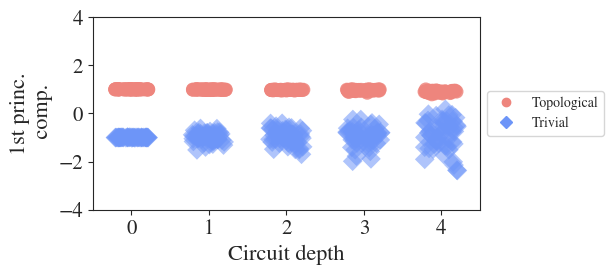

In [4]:
from matplotlib.lines import Line2D

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

# Perform kernel PCA based on shadow kernel
data = []
for d in range(DEPTH):
    K = depthkernels[d]
    X = []
    for i in range(len(K)):
        single_X = []
        for j in range(len(K)):
            single_X.append(K[i][j] / ((K[i][i] * K[j][j]) ** 0.5))
        X.append(single_X)
        
    X = np.array(X)
    pca = PCA(n_components=1)
    F = pca.fit_transform(X)
    std = np.std(F)
    
    for z in range(len(X)):
        data.append((-F[z, 0] / std, d, "Topological" if z < 50 else "Trivial"))

# Plot the 1D representation for different circuit depth
plt.figure(figsize=(5.0, 2.5))

df_toric = pd.DataFrame(data=data, columns = ['PC1', 'Depth', 'Phase'])
ax = sns.stripplot(x="Depth", y="PC1", hue='Phase', data=df_toric[df_toric["Phase"]=="Topological"], palette=['#EE857D'], orient="v", edgecolor="black", marker="o", s=10, alpha=0.85, jitter=0.22)
ax = sns.stripplot(x="Depth", y="PC1", hue='Phase', data=df_toric[df_toric["Phase"]=="Trivial"], palette=['#6D95F8'], orient="v", edgecolor="black", marker="D", s=10, alpha=0.55, jitter=0.22)

# Update the legend oreder
handles, labels = ax.get_legend_handles_labels()
handles = [Line2D([], [], color=h.get_facecolor(), linestyle='', marker="D" if l=='Trivial' else "o") for h, l in zip(handles, labels)]
labels, handles = zip(*sorted(zip(labels, handles)))

ax.legend( handles,labels,bbox_to_anchor=(1.0, 0.5),ncol = 1,loc="center left")

ax.set_xlabel("Circuit depth", fontsize = 16)
ax.set_ylabel("1st princ.\n comp.", fontsize = 16)
ax.tick_params(labelsize=15)
ax.set_ylim(-4.0, 4.0);

plt.show()

##### 2. USING ONLY LENGTH AS FEATURE

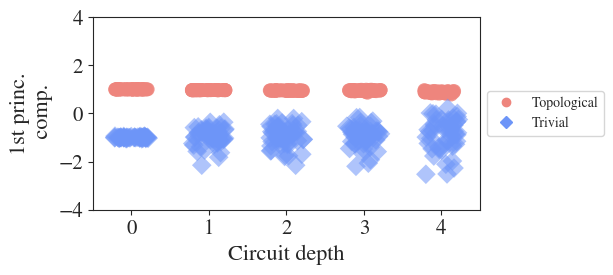

In [5]:
# Perform kernel PCA based on shadow kernel
data = []
for d in range(DEPTH):
    K = depthkernels[d] 
    X = np.array(np.diag(K).reshape(-1, 1)) #reshape cause 1d feature 
    pca = PCA(n_components=1)
    F = pca.fit_transform(X)
    std = np.std(F)
    
    for z in range(len(X)):
        data.append((-F[z, 0] / std, d, "Topological" if z < 50 else "Trivial"))

        
# Plot the 1D representation for different circuit depth
plt.figure(figsize=(5.0, 2.5))

df_toric = pd.DataFrame(data=data, columns = ['PC1', 'Depth', 'Phase'])
ax = sns.stripplot(x="Depth", y="PC1", hue='Phase', data=df_toric[df_toric["Phase"]=="Topological"], palette=['#EE857D'], orient="v", edgecolor="black", marker="o", s=10, alpha=0.85, jitter=0.22)
ax = sns.stripplot(x="Depth", y="PC1", hue='Phase', data=df_toric[df_toric["Phase"]=="Trivial"], palette=['#6D95F8'], orient="v", edgecolor="black", marker="D", s=10, alpha=0.55, jitter=0.22)

# Update the legend oreder
handles, labels = ax.get_legend_handles_labels()
handles = [Line2D([], [], color=h.get_facecolor(), linestyle='', marker="D" if l=='Trivial' else "o") for h, l in zip(handles, labels)]
labels, handles = zip(*sorted(zip(labels, handles)))

ax.legend( handles,labels,bbox_to_anchor=(1.0, 0.5),ncol = 1,loc="center left")

ax.set_xlabel("Circuit depth", fontsize = 16)
ax.set_ylabel("1st princ.\n comp.", fontsize = 16)
ax.tick_params(labelsize=15)
ax.set_ylim(-4.0, 4.0);

plt.show()